# WIG20 - Portfolio Management Strategies

### Loading the Packages and Data

In [1]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

In [2]:
dataset = pd.read_csv("WIG20_Index_Components.csv")
dataset = dataset.set_index("Data")

<AxesSubplot:title={'center':'Correlation Matrix'}>

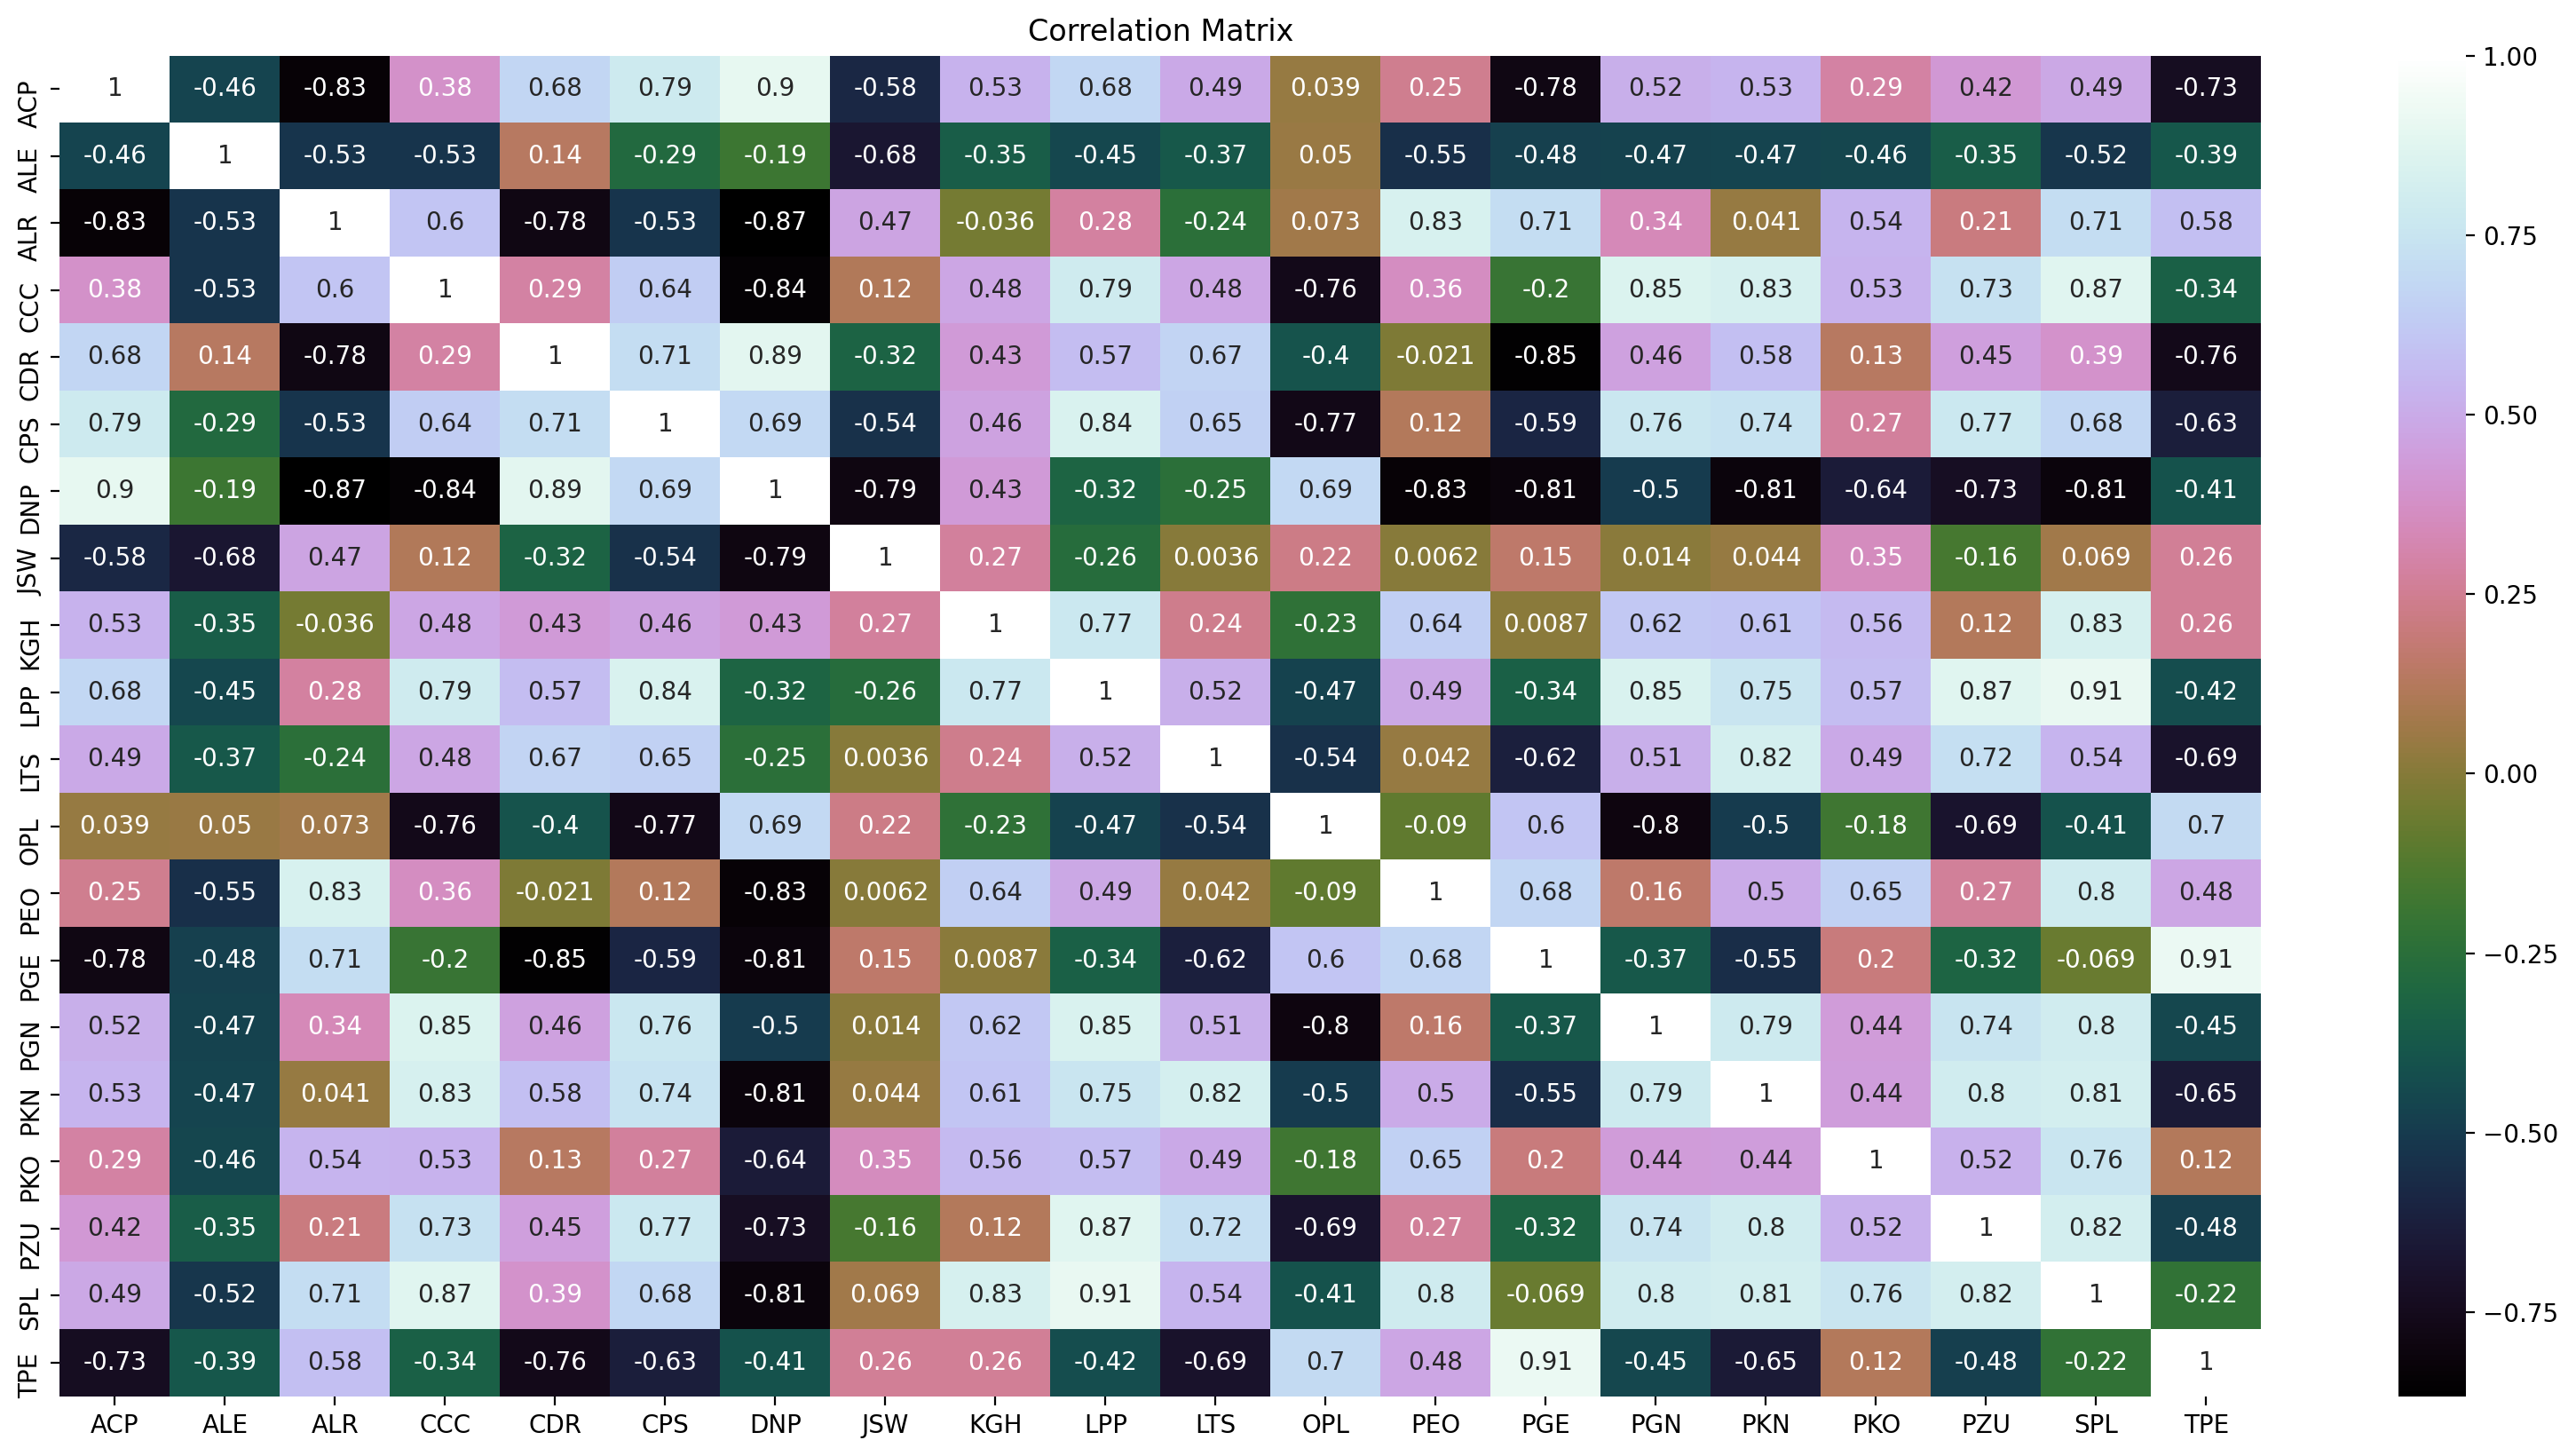

In [3]:
correlation = dataset.corr()
plt.figure(figsize = (20, 10))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax = 1, annot = True, cmap = 'cubehelix')

## Data Preparation

In [4]:
print(f"Null values: {dataset.isnull().values.any()}")
print(f"Null values sum: {dataset.isnull().values.sum()}")

Null values: True
Null values sum: 56973


In [5]:
print(f"Percentage of null values for each component: \n{dataset.isnull().mean()}")

Percentage of null values for each component: 
ACP    0.164585
ALE    0.987215
ALR    0.700955
CCC    0.406613
CDR    0.031888
CPS    0.530051
DNP    0.859662
JSW    0.647318
KGH    0.131962
LPP    0.283174
LTS    0.423071
OPL    0.181778
PEO    0.167083
PGE    0.586040
PGN    0.434093
PKN    0.219398
PKO    0.401763
PZU    0.604555
SPL    0.001470
TPE    0.609552
dtype: float64


In [6]:
missing_fractions = dataset.isnull().mean().sort_values(ascending = False)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
dataset.drop(drop_list, axis = 1, inplace = True)
dataset.shape

(6805, 8)

Removing the rows that contain missing values

In [14]:
dataset = dataset.fillna(method='ffill')

dataset = dataset.dropna(axis = 0)
dataset[:2]

,ACP,CDR,KGH,LPP,OPL,PEO,PKN,SPL
Data,,,,,,,,
2001-05-16,21.378,9.583,7.3298,41.607,9.4452,35.881,12.966,30.968
2001-05-17,21.923,9.750,7.3994,41.521,9.6330,35.775,12.929,31.395


In [15]:
# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

## Scaling the Features

In [16]:
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,ACP,CDR,KGH,LPP,OPL,PEO,PKN,SPL
Data,,,,,,,,
2001-05-17,1.370215,0.664914,0.388907,-0.159567,1.172552,-0.156364,-0.157288,0.713049
2001-05-18,-0.011056,-0.295098,-0.031536,-1.023227,0.579557,0.565090,0.444538,0.340083


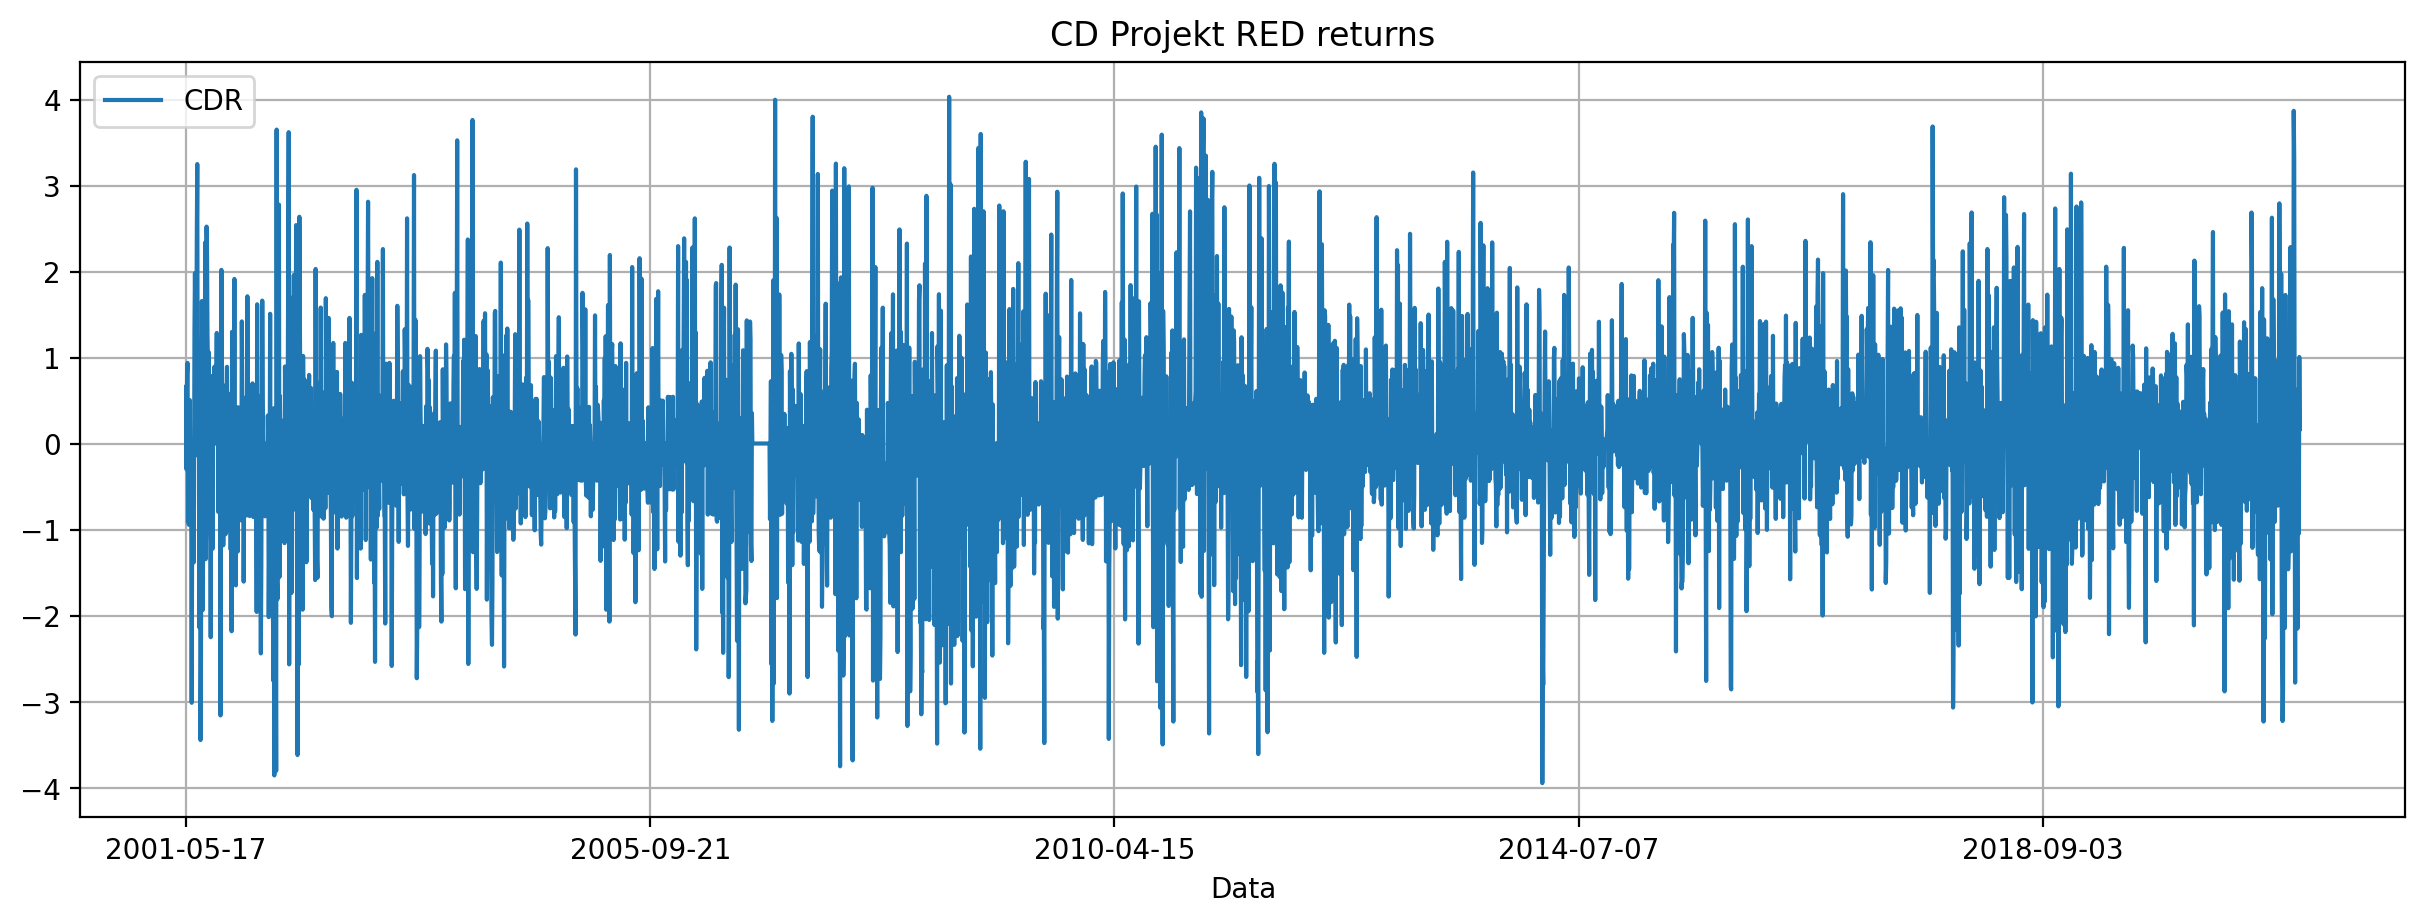

In [17]:
plt.figure(figsize = (15, 5))
plt.title("CD Projekt RED returns")
rescaledDataset.CDR.plot()
plt.grid(True)
plt.legend()
plt.show()

## Models/Algorithms

In [18]:
# Splitting the data into training and test sets
split_size = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:split_size]
X_test = rescaledDataset[split_size:]

X_train_raw = datareturns[:split_size]
X_test_raw = datareturns[split_size:]

stock_tickers = rescaledDataset.columns.values
no_of_tickers = len(stock_tickers)

In [19]:
pca = PCA()
prcpcomponents = pca.fit(X_train)

In [20]:
pca.components_[0]

array([0.33585672, 0.26319464, 0.41123886, 0.19241054, 0.35787525,
       0.42951491, 0.39099748, 0.38256091])

Key points:
* "The decline in the amount of variance of the original data explained by each principal component **reflects the extent of correlation among the original features**"

* Eigenvectors with the **LOWEST** eigenvalues describe the LEAST AMOUNT OF VARIATION within the dataset. These values can be dropped. 

<AxesSubplot:title={'center':'Cumulative Explained Variance'}>

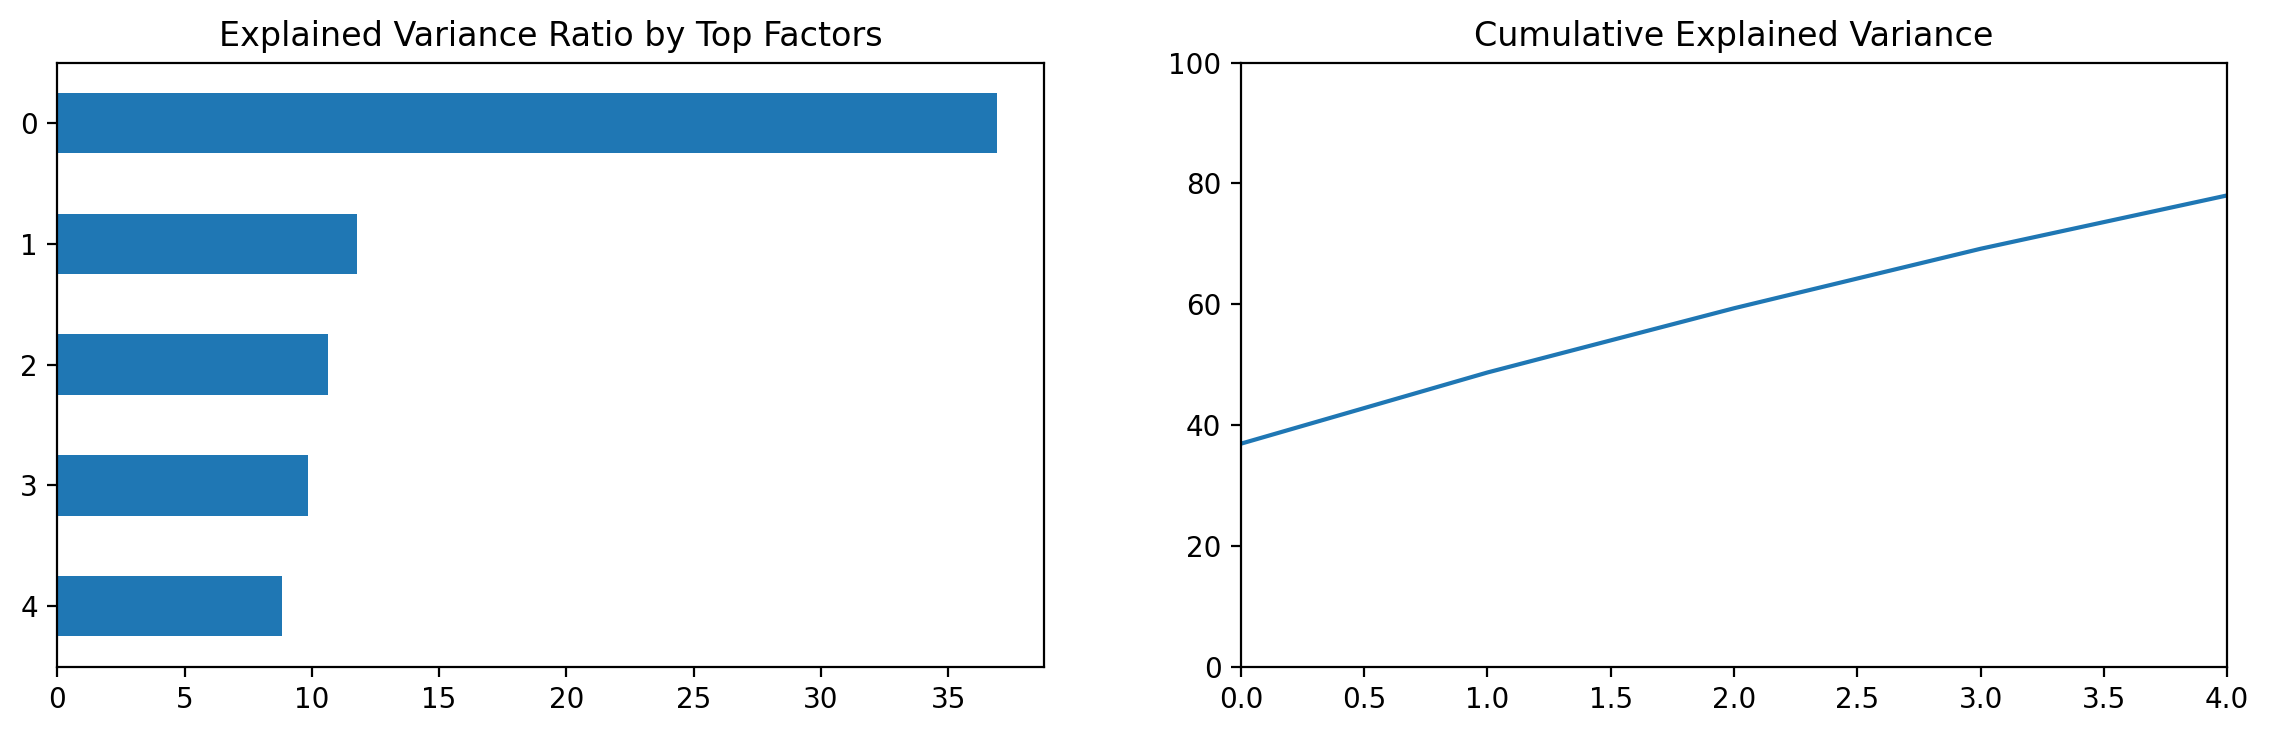

In [23]:
# Let's pick 5 eigenvalues
num_eigenvalues = 5

fig, ax = plt.subplots(ncols = 2, figsize = (14, 4))
explainedVariance = pd.Series(pca.explained_variance_ratio_[:num_eigenvalues]).sort_values() * 100
cumulativeVariance = pd.Series(pca.explained_variance_ratio_[:num_eigenvalues]).cumsum() * 100

explainedVariance.plot.barh(title = "Explained Variance Ratio by Top Factors", ax = ax[0])
cumulativeVariance.plot(ylim = (0,100), xlim = (0,4), ax = ax[1], title = "Cumulative Explained Variance")

As expected, the first principal component captures the most variance in the original data.

In [24]:
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(num_eigenvalues).style.format('{:,.2%}'.format)

,Explained Variance
0,36.89%
1,48.69%
2,59.32%
3,69.17%
4,78.00%


In [25]:
pca.explained_variance_ratio_[:num_eigenvalues]

array([0.36894176, 0.11791371, 0.10634014, 0.09851045, 0.08834011])

##### Interpretation of the PCA

* The most important factor explains around 37% of the daily return variation. That dominant principal component is usually interpreted as **market factor**

* The cumulative explained variance shows that 5 factors explain 78% of the variance in the returns of the 8 stocks that were analyzed.

All in all, we managed to reduce the number of dimensions, and retain 78% of the information. Next step is a closer inspection of the principal components weights, and portfolio construction

### Portfolio weights inspection

* Even though portfolio weights may be less interpretable (as compared to the original features), but we can look at the weights for each factor on each principal component and see if there are some patterns in the 8 stocks that we are analyzing 

In [38]:
print(f"No. of components: {len(pca.components_)}")
print(f"No. of weights within the components: {len(pca.components_[0])}")

No. of components: 8
No. of weights within the components: 8


In [39]:
def PrincipalWeights():
    weights = pd.DataFrame()
    
    for i in range(len(pca.components_)):
        weights[f"weights_{i}"] = pca.components_[i] / sum(pca.components_[i])
    
    weights = weights.values.T
    
    return weights

In [40]:
weights = PrincipalWeights()

##### Constructing Five Portfolios

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>],
       [<AxesSubplot:title={'center':'Portfolio 4'}>]], dtype=object)

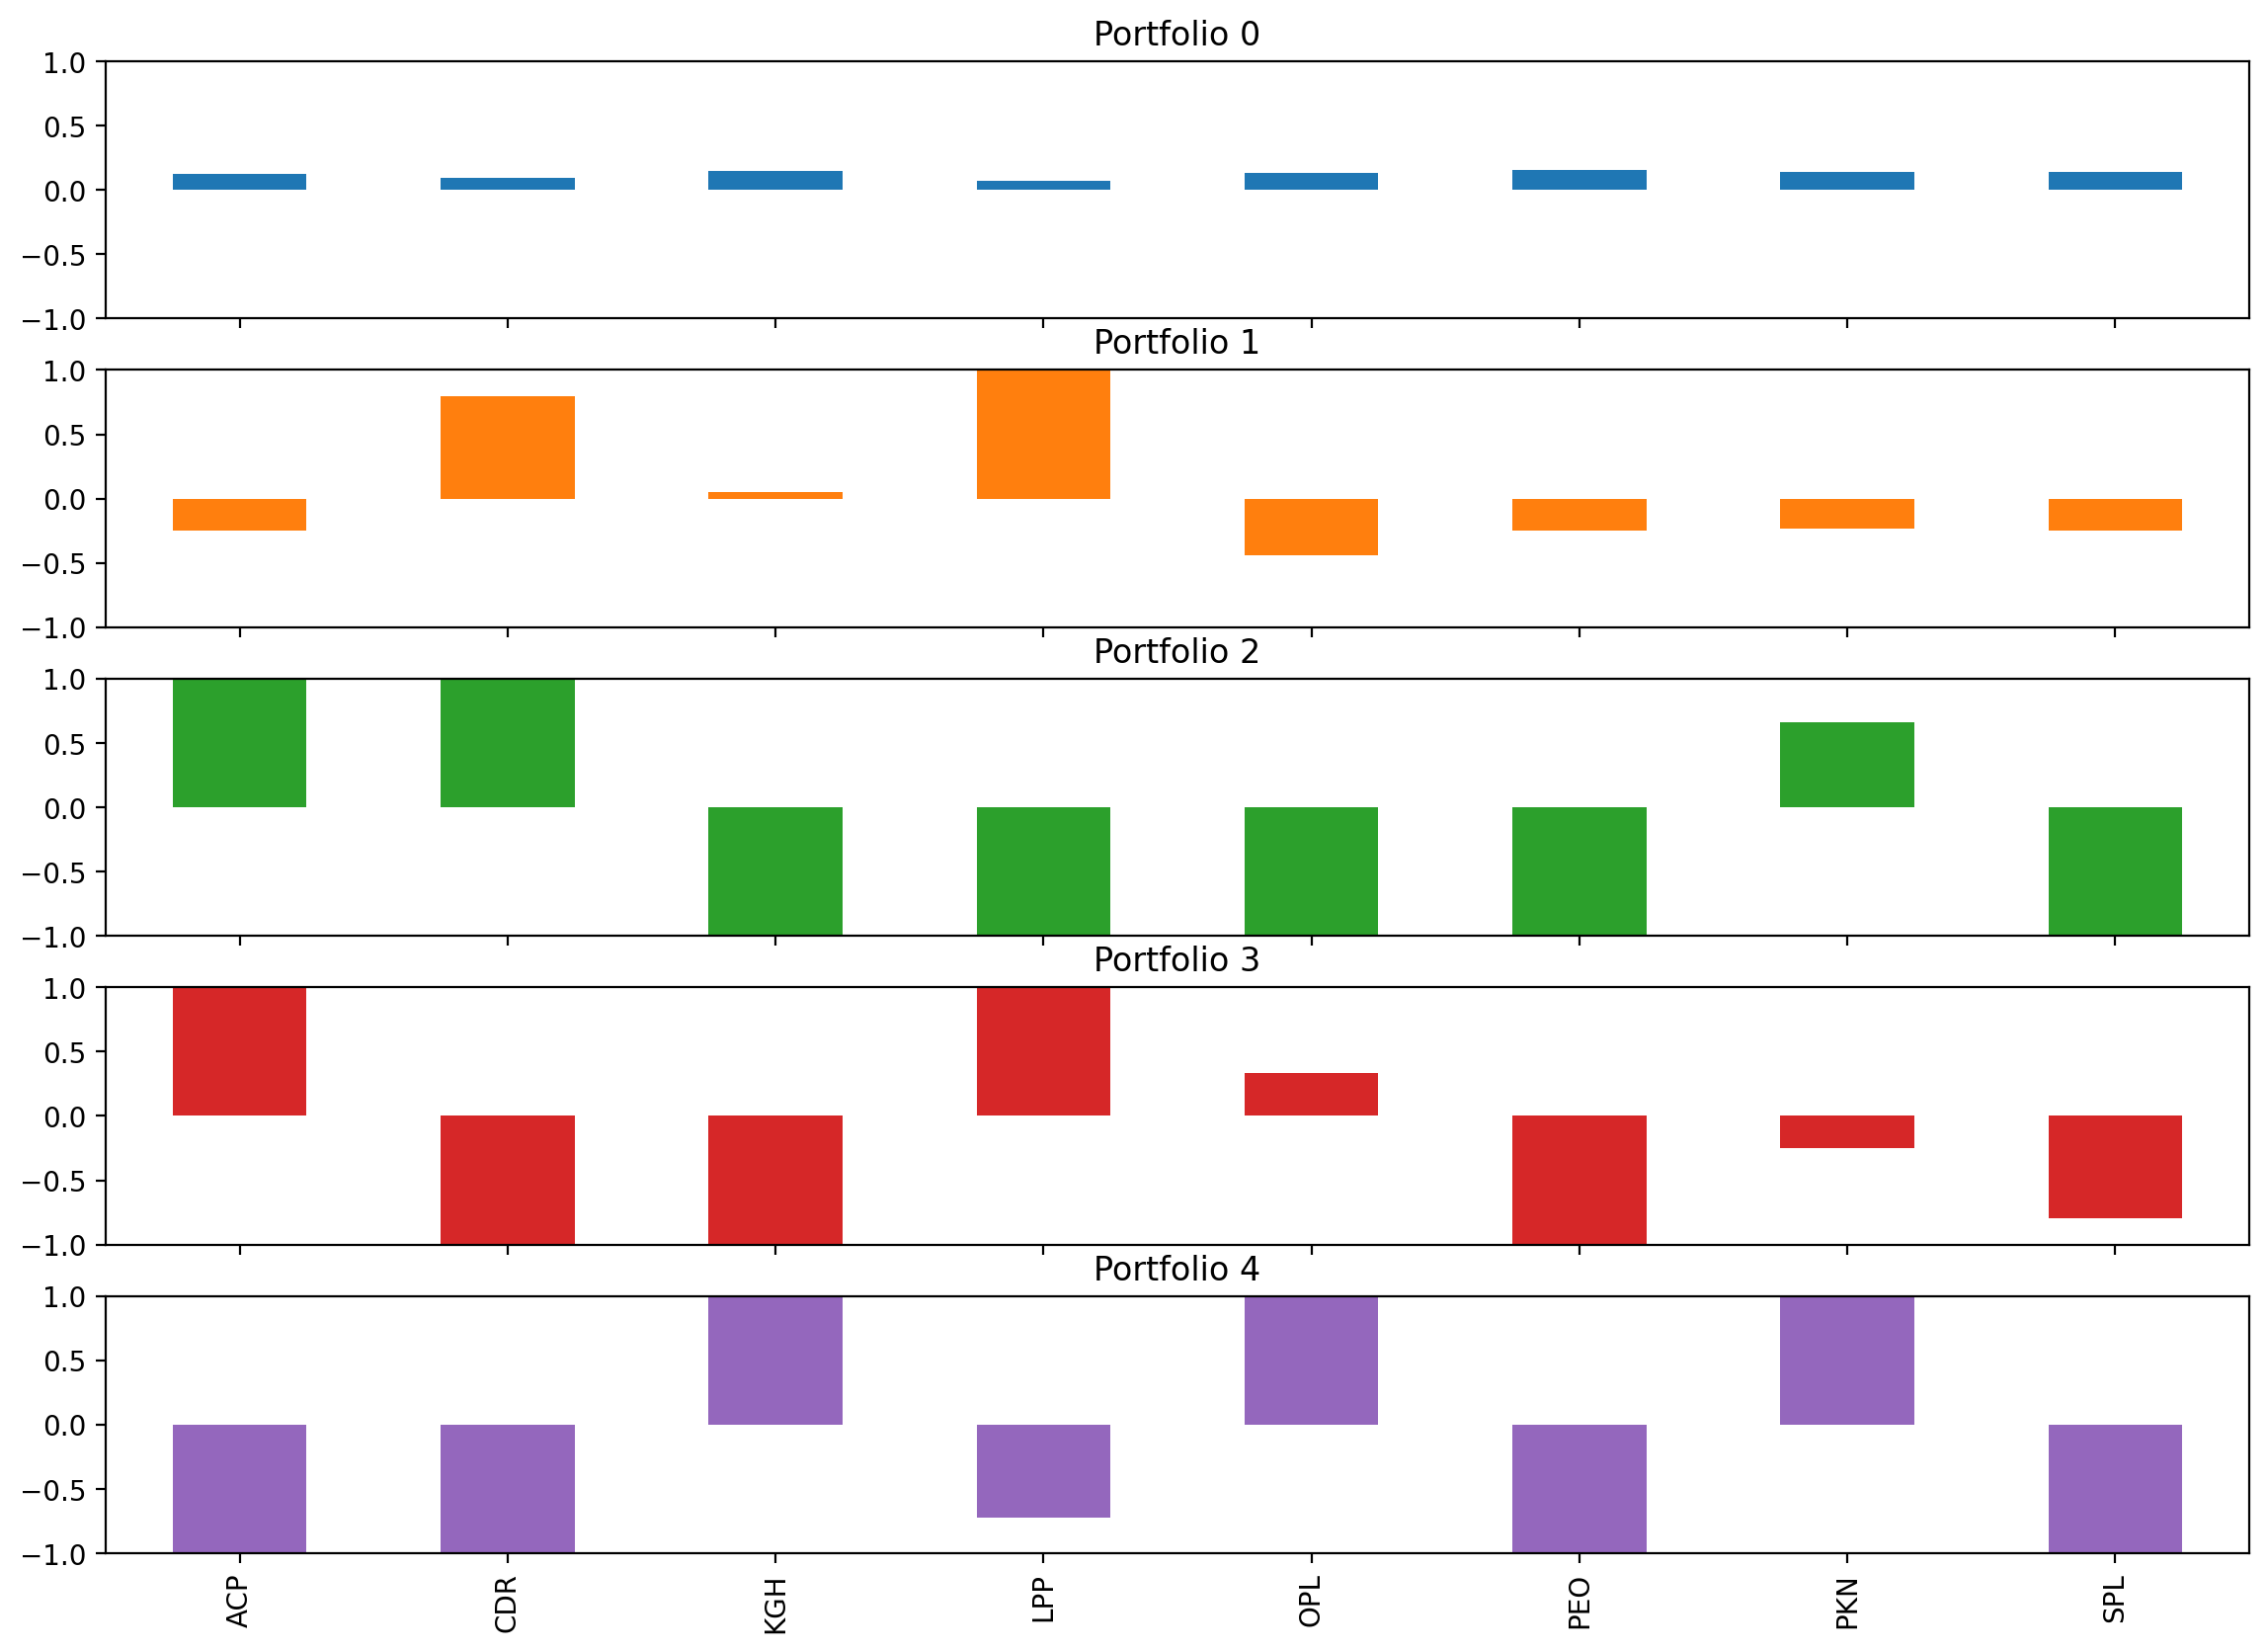

In [41]:
numComponents = 5

topPortfolios = pd.DataFrame(pca.components_[:numComponents], 
                             columns = dataset.columns)
eigenPortfolios = topPortfolios.div(topPortfolios.sum(1), axis = 0)
eigenPortfolios.index = [f"Portfolio {i}" for i in range(numComponents)]
np.sqrt(pca.explained_variance_)
eigenPortfolios.T.plot.bar(subplots = True, layout = (int(numComponents), 1), 
                           figsize = (14, 10), 
                           legend = False, 
                           sharey = True, 
                           ylim = (-1,1))

<AxesSubplot:>

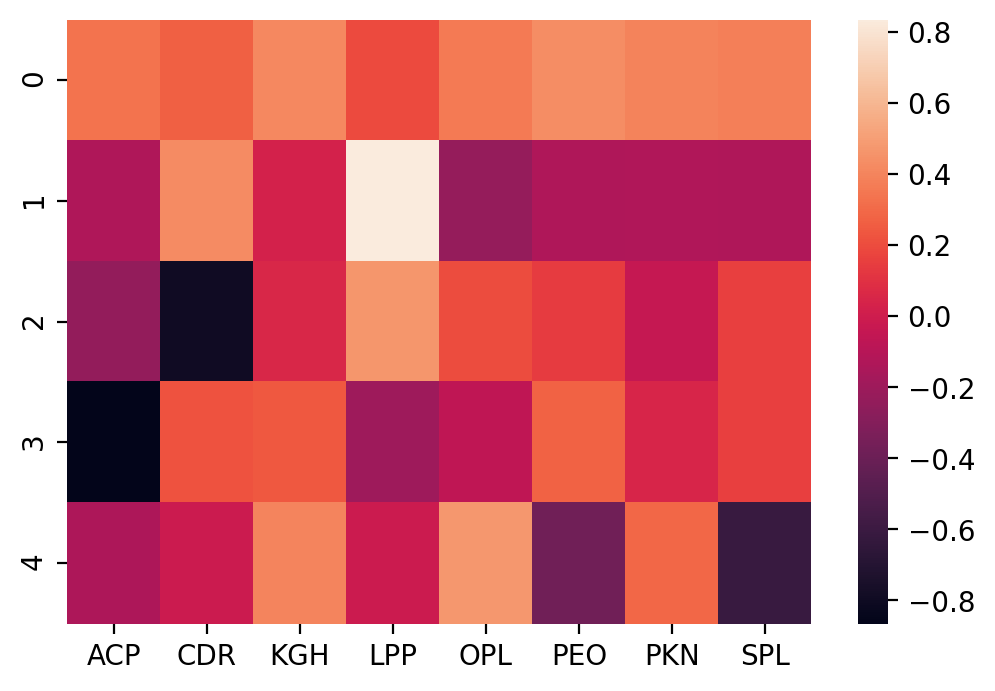

In [31]:
sns.heatmap(topPortfolios)

### Interpretation of the plots 

The heatmap and barplots show the contribution of different stocks in each eigenvector.

Traditionally, the intuition behind each principal portfolio is that it represents some sort of independent risk factor. The manifestation of those risk factors depends on the assets in the portfolio. In this case, the index is mostly comprised of domestic equities (even though it's hard to classify Orange as a [truly] domestic equity). **The principal portfolio with the largest variance usually denotes a systematic risk factor ("market" factor)**. Portfolio #0 captures this risk factor, as weights are distributed evenly across the stocks. This (nearly) equally weighted portfolio explains 37% of the variance in the index and is a **representation of a systemic risk factor**.

Usually, the rest of the portfolios would correspond to sector or industry factors. However, in this case, it's hard to draw such strict lines. For example, Portfolio #4 contains companies such as KGH, OPL, PKN. KGH is a company that produces silver and copper (on a global scale), OPL is Orange, one of the biggest telecommunications company (coming from France), and PKN is a company from the fuels and energy industry. Certainly, these companies are coming from different sectors. The only common theme for them is the fact that they are the biggest players in their respective industries. Same can be said about Portfolio #3, where the highest weights were assigned to companies from IT, and clothing industries, respectively. 

### Finding the Best Eigen Portfolio

* In order to determine the best eigen portfolio, we use **Sharpe ratio**.

*Sharpe ratio* - is an assessment of risk-adjusted performance that explains the annualized returns against the annualized volatility of a portfolio. A **high Sharpe ratio explains higher and/or lower volatility of a portfolio**.

To calculate annualized returns:
- we apply geometric average of all the returns in respect to the periods per year (days of operation in the exchange in a year).

To calculate annualized volatility:
- we take the standard deviation of the returns and multiply them by the square root of periods per year.

In [32]:
def SharpeRatio(ts_returns, periods_per_year = 252):
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

Now we are going to construct a loop to compute principal component weights for each eigen portfolio. Then we will use the Sharpe Ratio function to look for the portfolio with the **highest Sharpe ratio**. Once we retrieve the portfolio with the highest Sharpe ratio, we can visualize its performance against the index for comparison.

In [33]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    
    for i in range(n_portfolios):
        pc_weights = pcs[i] / sum(pcs[i])
        eigen_portfolio = pd.DataFrame(data = {'weights': pc_weights.squeeze() * 100},
                                      index = stock_tickers)
        eigen_portfolio.sort_values(by = ['weights'], ascending = False, inplace = True)
        eigen_portfolio_returns = np.dot(X_train_raw.loc[:, eigen_portfolio.index], pc_weights)
        eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index = X_train_raw.index)
        
        er, vol, sharpe = SharpeRatio(eigen_portfolio_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    highest_sharpe = np.argmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth = 3)
    ax.set_title("Sharpe ratio of eigen portfolios")
    ax.set_ylabel("Sharpe ratio")
    ax.set_xlabel("Portfolios")
    
    
    results = pd.DataFrame(data= {"Return": annualized_ret, 
                                  "Vol": annualized_vol, 
                                  "Sharpe": sharpe_metric})
    results.dropna(inplace = True)
    results.sort_values(by = ['Sharpe'], ascending = False, inplace = True)
    print(results.head(5))
    plt.show()

<ipython-input-32-f668c3eacbe5>:3: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1 + ts_returns), (1/n_years))-1


Eigen portfolio #0 with the highest Sharpe. Return 4.76%, vol = 18.99%, Sharpe = 0.25
     Return        Vol    Sharpe
0  0.047636   0.189877  0.250879
6 -1.000000  11.022738 -0.090722
7 -0.998502   3.325370 -0.300268
1 -0.220247   0.554007 -0.397552
3 -0.586123   1.415398 -0.414105


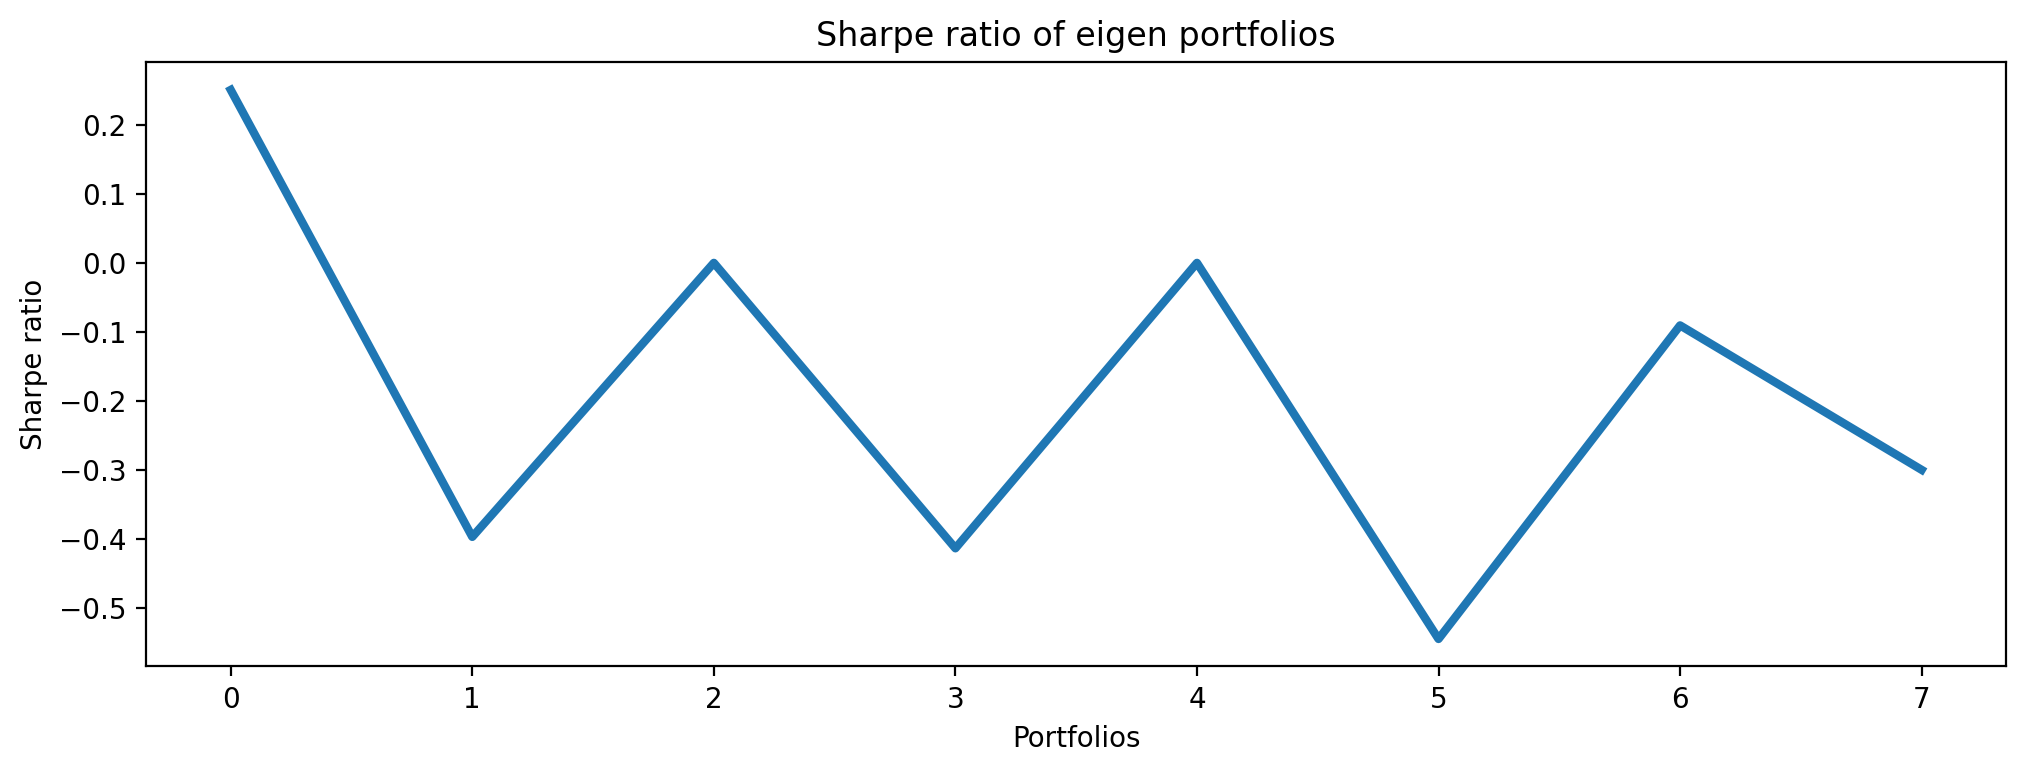

In [34]:
optimizedPortfolio()

The plot above confirms the initial hypothesis that Portfolio #0 is the best performing one, with the highest return and the lowest volatility. Now it's time to inspect the composition of this portfolio:

In [42]:
weights = PrincipalWeights()
portfolio = portfolio = pd.DataFrame()

In [43]:
def plotEigen(weights, plot = False, portfolio = portfolio):
    portfolio = pd.DataFrame(data = {"weights": weights.squeeze() * 100}, index = stock_tickers)
    portfolio.sort_values(by = ['weights'], ascending = False, inplace = True)
    
    if plot:
        portfolio.plot(title = "Current Eigen-Portfolio Weights",
                      figsize = (12,6),
                      xticks = range(0, len(stock_tickers), 1),
                      rot = 45,
                      linewidth = 3)
        plt.show()
        
    return portfolio

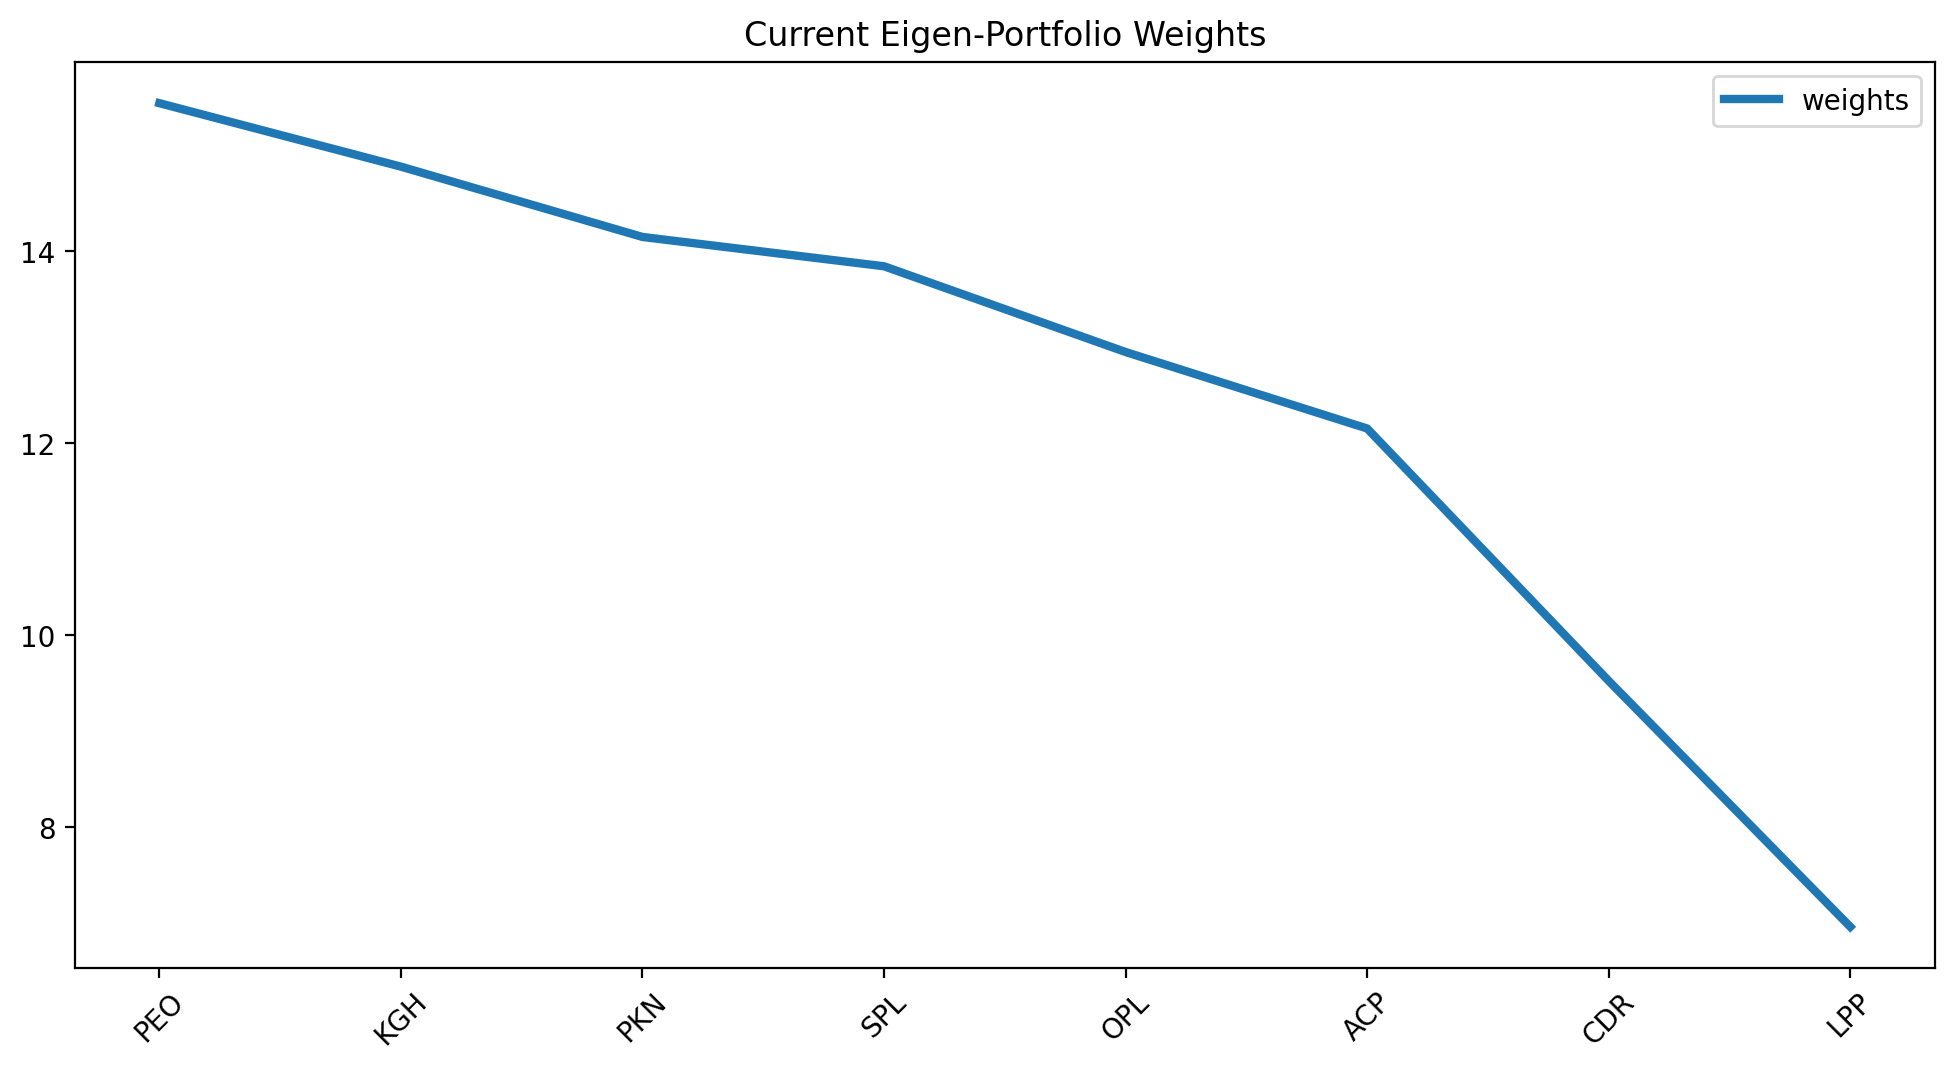

,weights
PEO,15.541585
KGH,14.880284
PKN,14.147869
SPL,13.842600
OPL,12.949373
ACP,12.152653
CDR,9.523446
LPP,6.962191


In [44]:
plotEigen(weights[0], plot = True)

As was mentioned before, Portfolio #0 explains 37% of the variance and represents the systematic risk factor. The portfolio weights (represented as percentages on the y-axis) are in the range of ~7% to 15% across all stocks. Highest weight was assigned to a company from **financial** industry (Pekao Bank), with KGH coming a close second, and PKN Orlen on the third place. 

## Backtesting Eigenportfolio

In [45]:
def Backtest(eigen):
    eigen_prtfi = pd.DataFrame(data = {'weights': eigen.squeeze()}, 
                                       index = stock_tickers)
    eigen_prtfi.sort_values(by = ['weights'], ascending = False, inplace = True)
    eigen_prtfi_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prtfi_returns.squeeze(), 
                                        index = X_test_raw.index)
    
    returns, vol, sharpe = SharpeRatio(eigen_portfolio_returns)
    print(f"Current Eigen-Portfolio: \nReturn = {np.round(returns * 100, 2)}, \nVolatility = {np.round(vol * 100, 2)}, \nSharpe = {sharpe}")
    equal_weight_return = (X_test_raw * (1 / len(pca.components_))).sum(axis = 1)
    df_plot = pd.DataFrame({"EigenPortfolio Return": eigen_portfolio_returns,
                            "Equal Weight Index": equal_weight_return},
                          index = X_test.index)
    
    np.cumprod(df_plot + 1).plot(title = "Returns of the equal weighted index vs. eigen-portfolio",
                                figsize = (12,6), linewidth = 3)
    plt.show()

Current Eigen-Portfolio: 
Return = 0.92, 
Volatility = 17.57, 
Sharpe = 0.05216341197729539


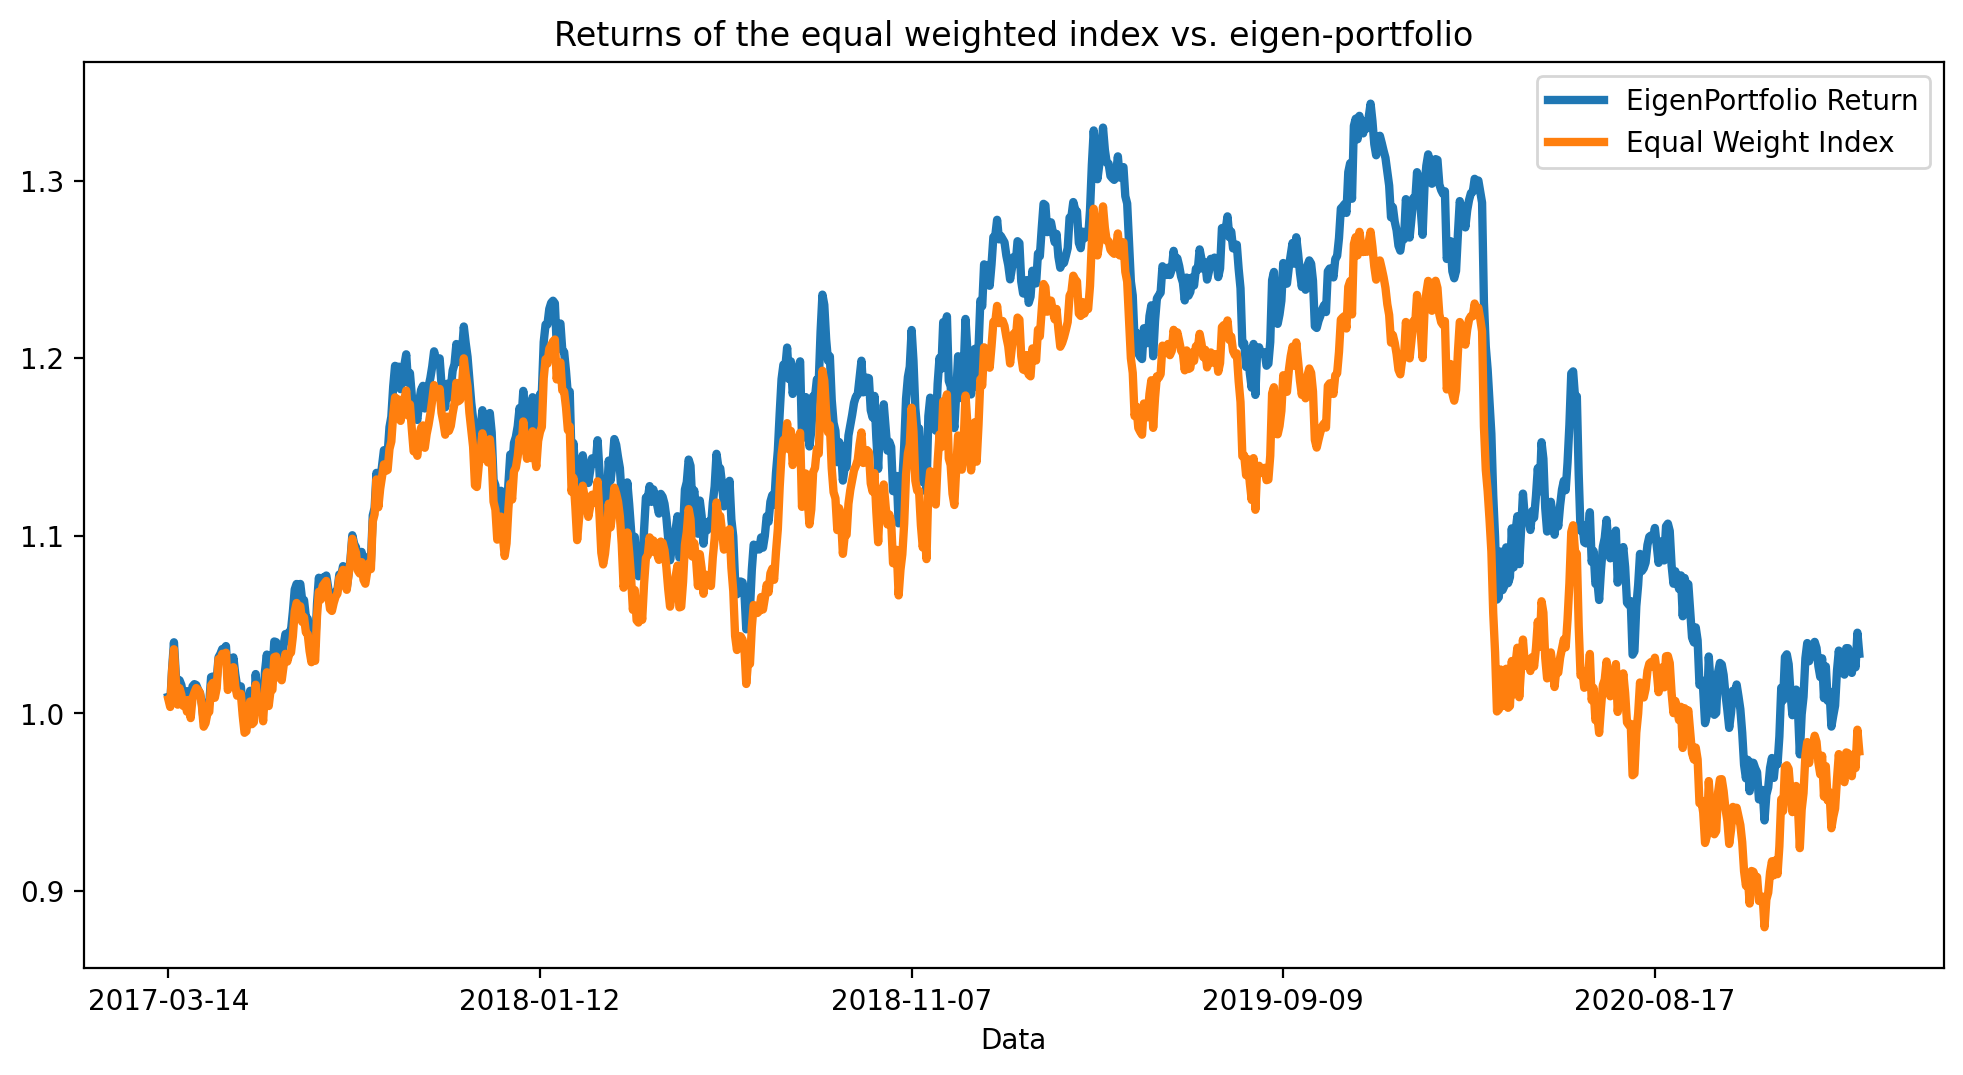

Current Eigen-Portfolio: 
Return = 9.06, 
Volatility = 122.35, 
Sharpe = 0.07405036893830197


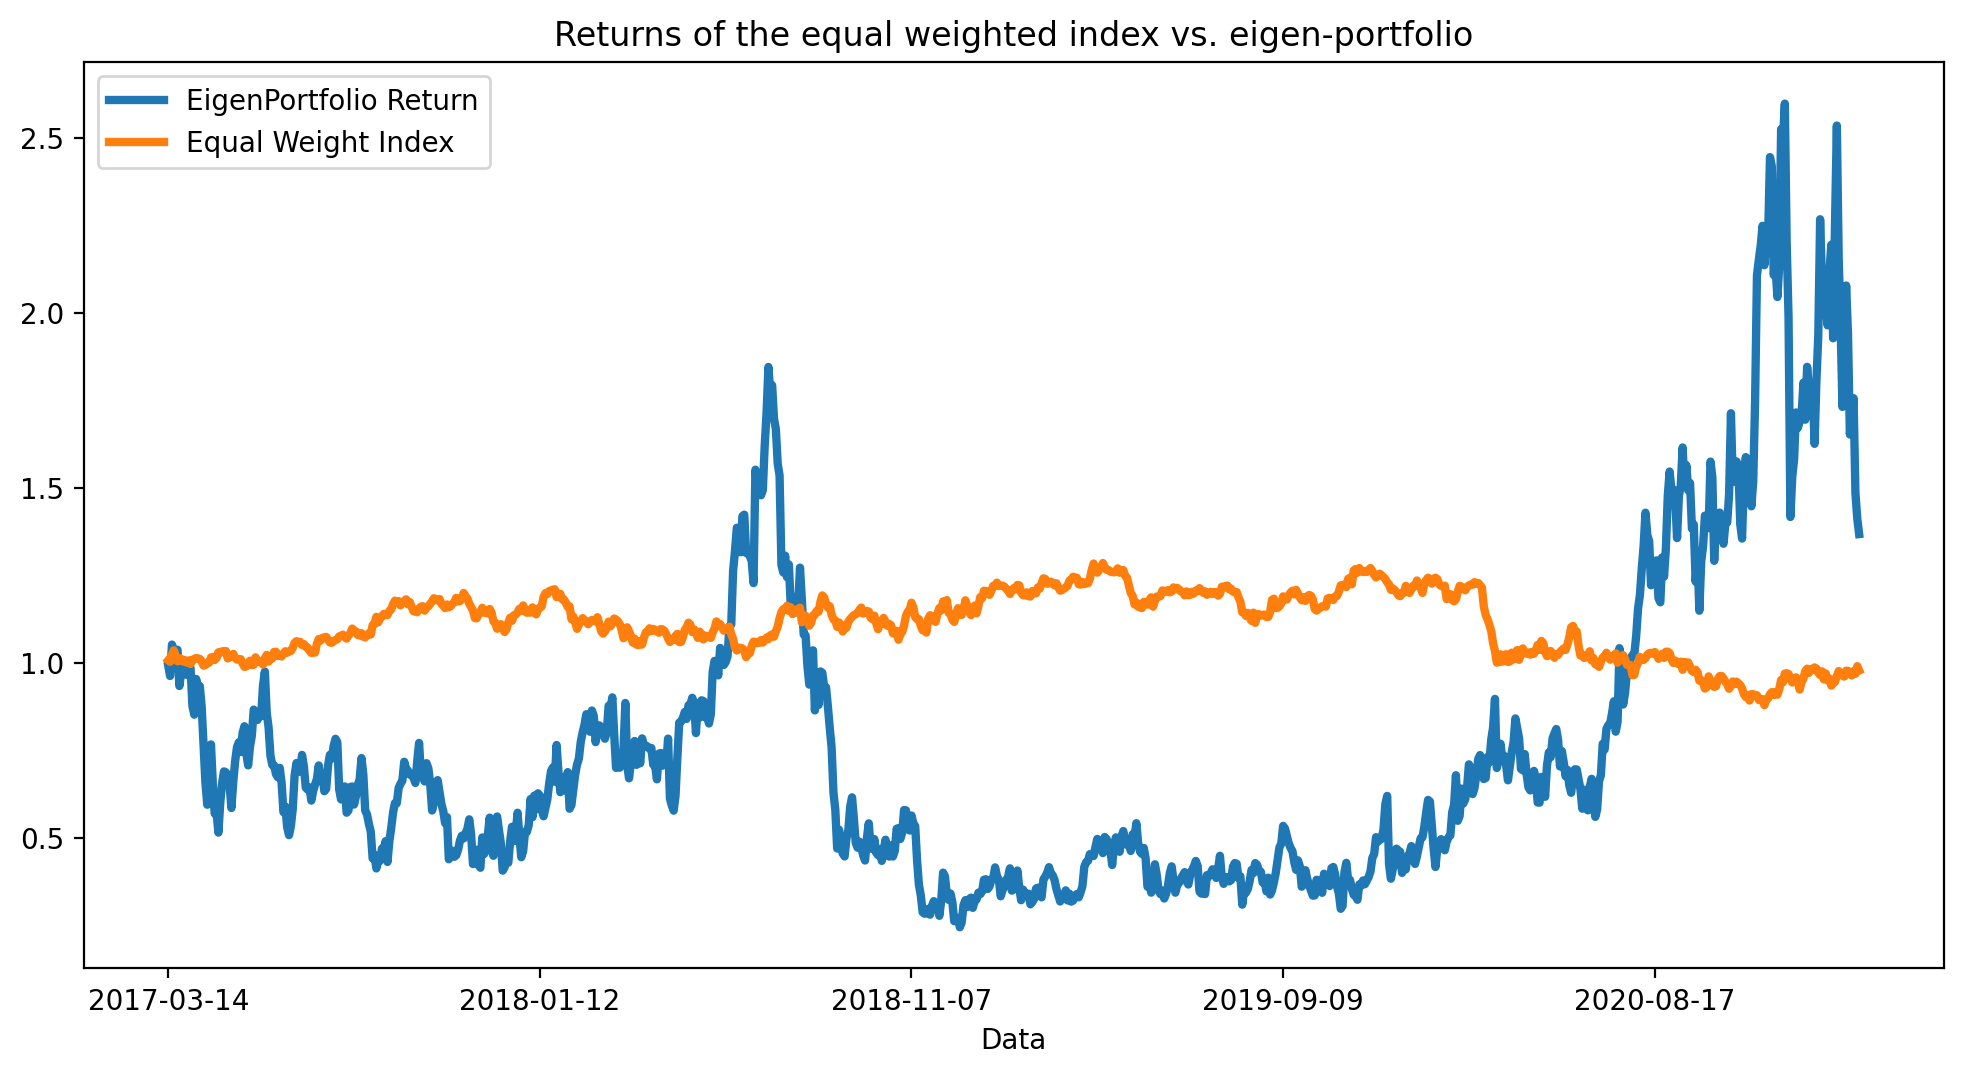

Current Eigen-Portfolio: 
Return = -65.63, 
Volatility = 135.2, 
Sharpe = -0.4854030262147311


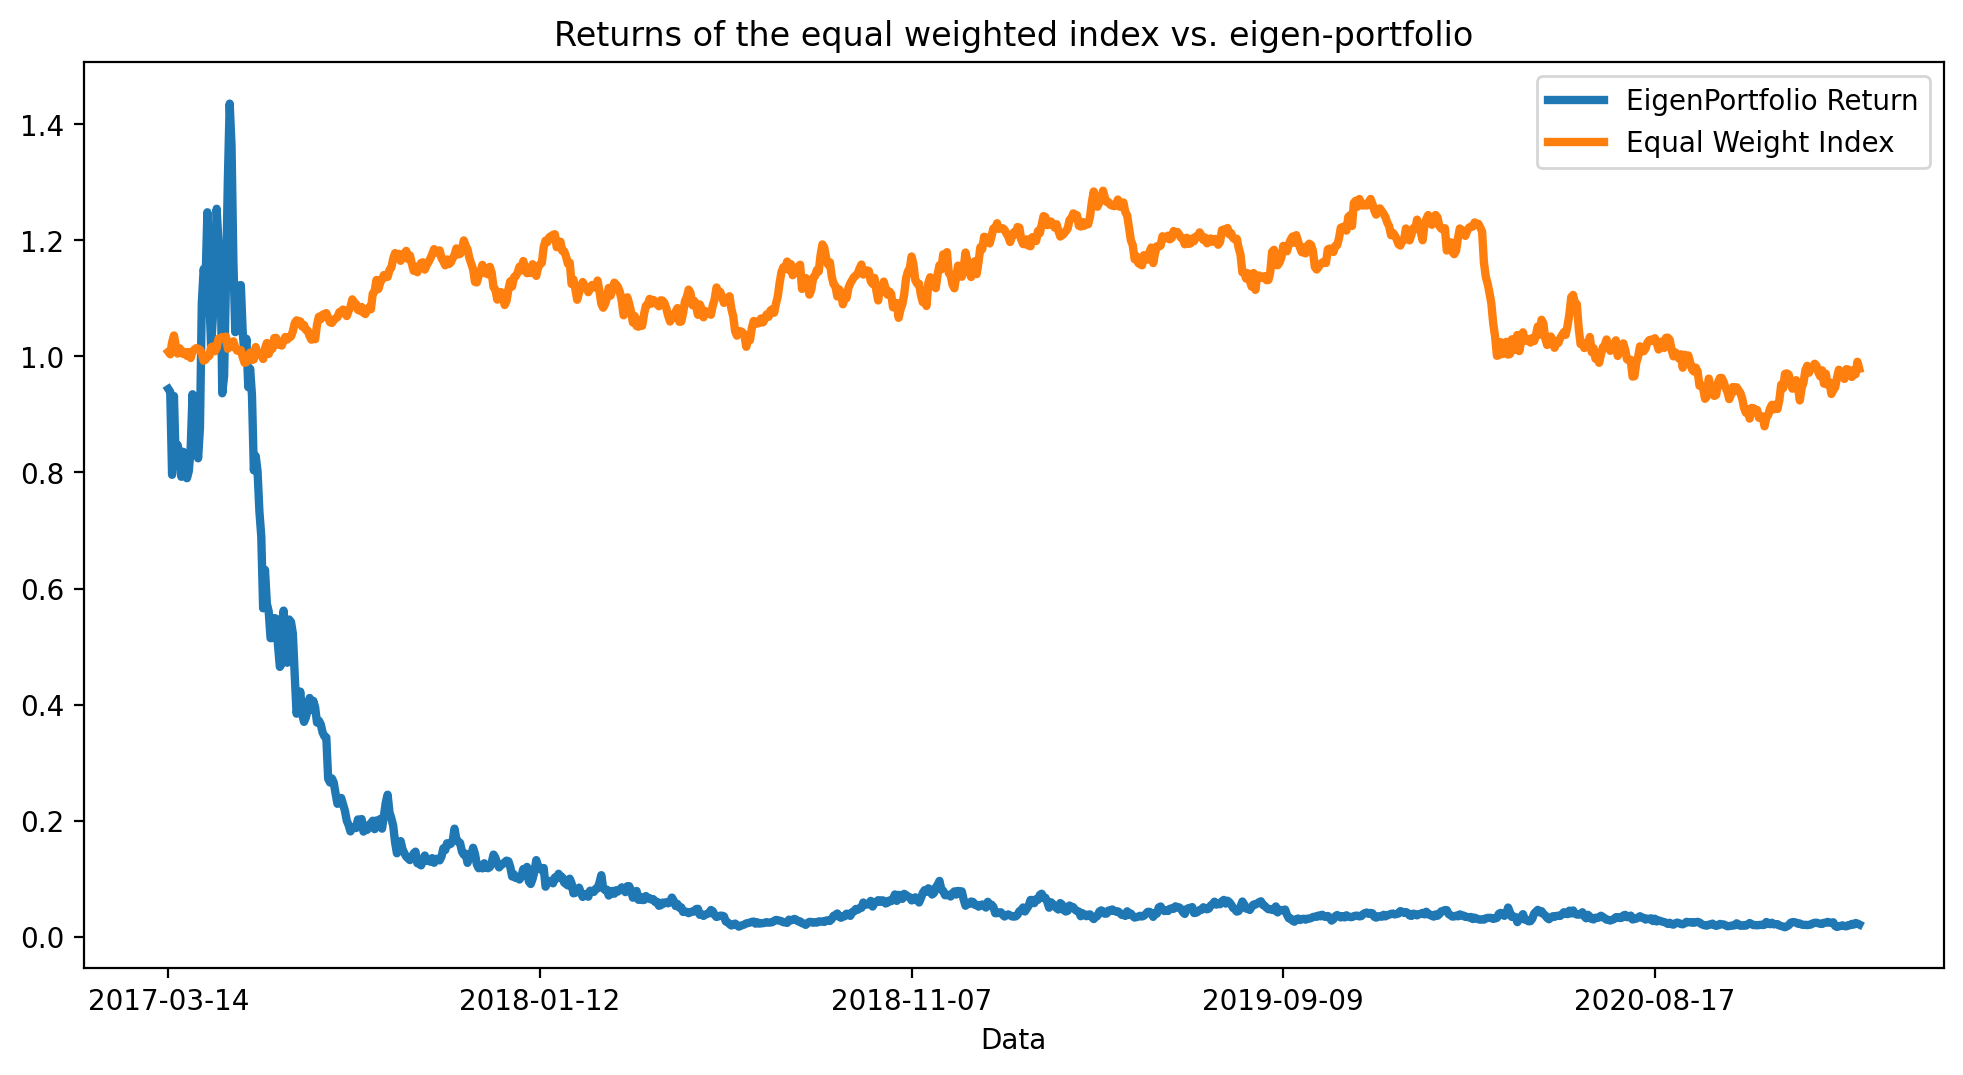

Current Eigen-Portfolio: 
Return = -99.01, 
Volatility = 301.42, 
Sharpe = -0.32847224153453297


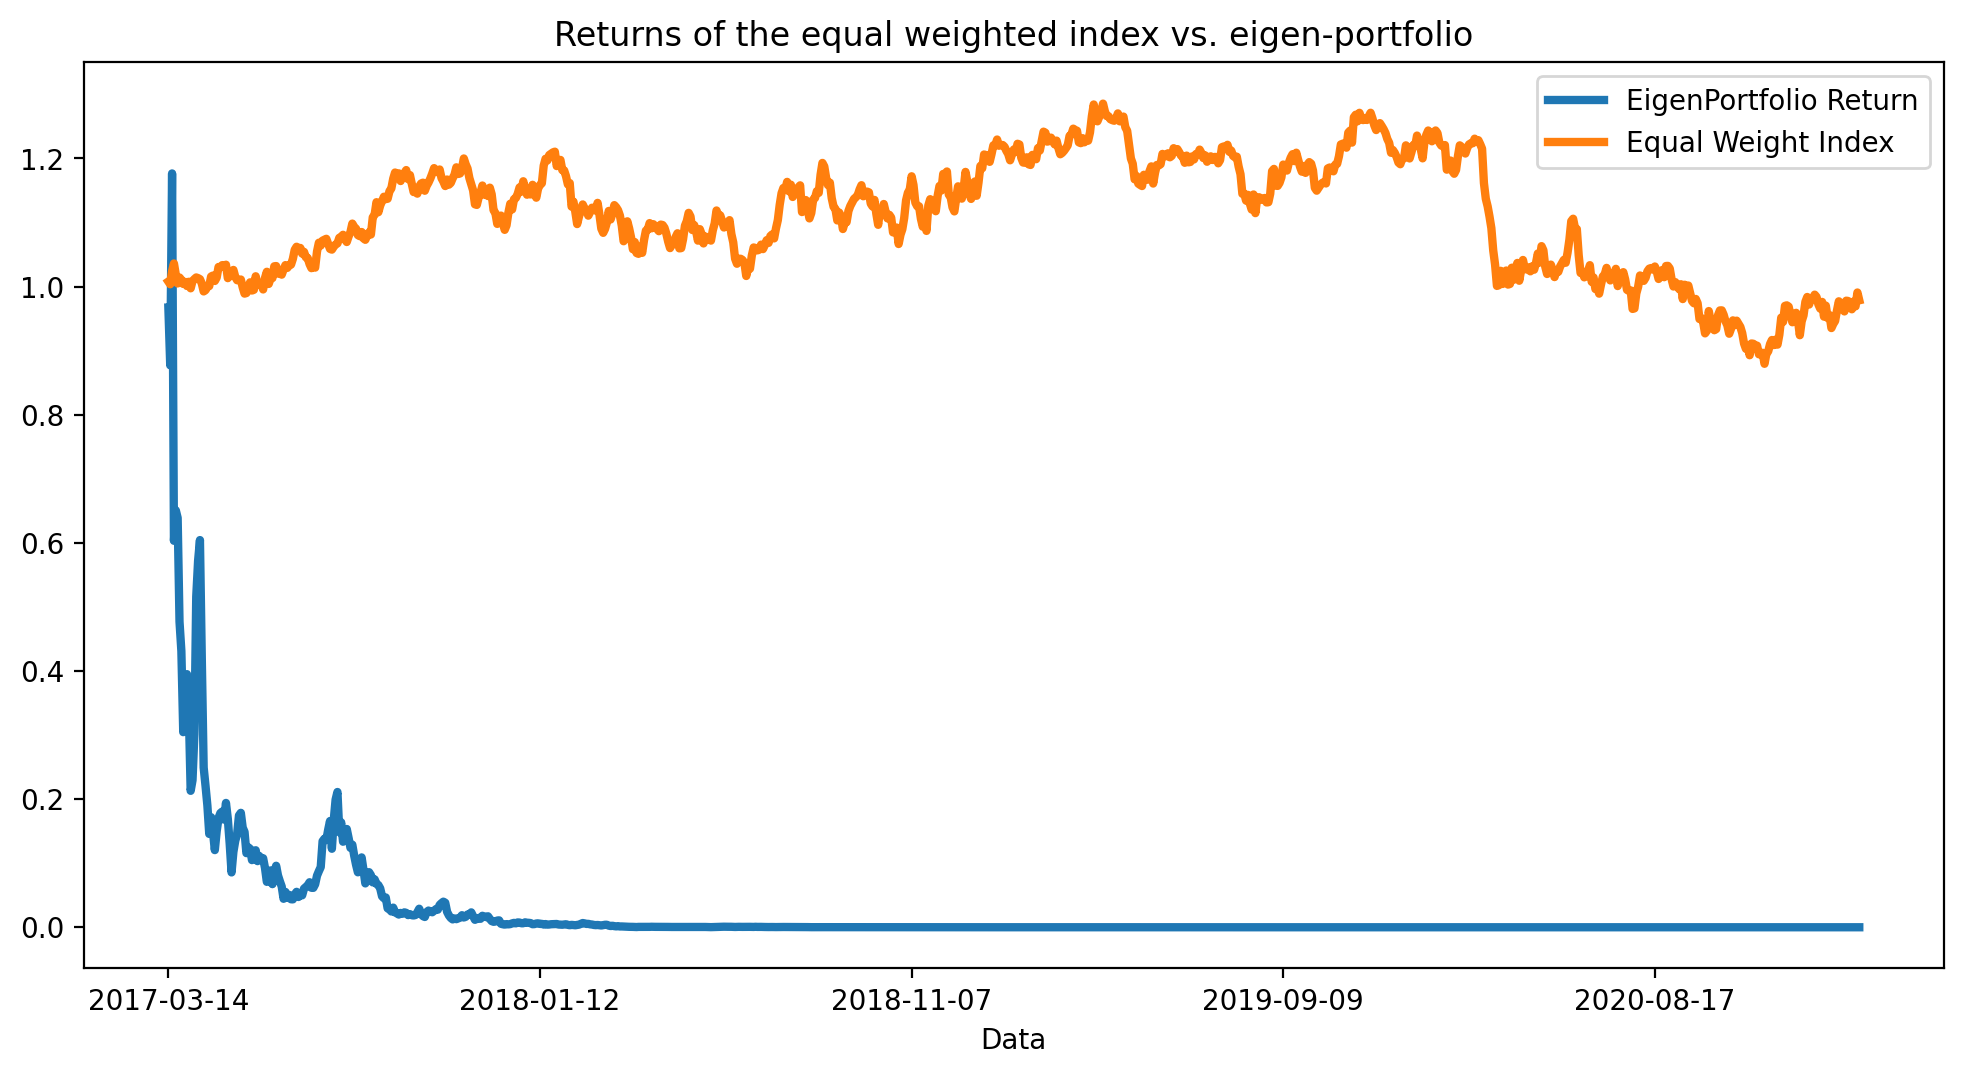

In [51]:
Backtest(weights[0])
Backtest(weights[5])
Backtest(weights[3])
Backtest(weights[7])